**(1)**

The Monte Carlo approach is simply an extreme version that just falls within the broad limitations of TD methods. To accomplish a Monte Carlo technique, set the number of steps n equal to episode length T in the pseudocode for n-step SARSA in section 10.2.

Furthermore, Monte Carlo approaches have a significant computing cost in practice. Monte Carlo methods will not begin to learn until the first episode is completed. Ending an episode can be difficult because the initial policy contains random weights, giving agents a natural tendency to repeat the same randomly initialized mistake again and over. SARSA and other TD algorithms can learn in real time, i.e. online, resulting in faster convergence.

**3**

In [35]:
#environment.py

from enum import IntEnum
from typing import Tuple, Optional, List
from gym import Env, spaces
from gym.utils import seeding
from gym.envs.registration import register
import random


def register_env() -> None:
    """Register custom gym environment so that we can use `gym.make()`

    In your main file, call this function before using `gym.make()` to use the Four Rooms environment.
        register_env()
        env = gym.make('FourRooms-v0')

    Note: the max_episode_steps option controls the time limit of the environment.
    You can remove the argument to make FourRooms run without a timeout.
    """
    register(id="FourRooms-v0", entry_point="env:FourRoomsEnv", max_episode_steps=459)


class Action(IntEnum):
    """Action"""

    LEFT = 0
    DOWN = 1
    RIGHT = 2
    UP = 3


def actions_to_dxdy(action: Action) -> Tuple[int, int]:
    """
    Helper function to map action to changes in x and y coordinates
    Args:
        action (Action): taken action
    Returns:
        dxdy (Tuple[int, int]): Change in x and y coordinates
    """
    mapping = {
        Action.LEFT: (-1, 0),
        Action.DOWN: (0, -1),
        Action.RIGHT: (1, 0),
        Action.UP: (0, 1),
    }
    return mapping[action]


class FourRoomsEnv(Env):
    """Four Rooms gym environment.

    This is a minimal example of how to create a custom gym environment. By conforming to the Gym API, you can use the same `generate_episode()` function for both Blackjack and Four Rooms envs.
    """

    def __init__(self, goal_pos=(10, 10)) -> None:
        self.rows = 11
        self.cols = 11
        self.max_steps = 459  # Maximum steps per episode
        self.current_step = 0  # Initialize step counter

        # Coordinate system is (x, y) where x is the horizontal and y is the vertical direction
        self.walls = [
            (0, 5),
            (2, 5),
            (3, 5),
            (4, 5),
            (5, 0),
            (5, 2),
            (5, 3),
            (5, 4),
            (5, 5),
            (5, 6),
            (5, 7),
            (5, 9),
            (5, 10),
            (6, 4),
            (7, 4),
            (9, 4),
            (10, 4),
        ]

        self.start_pos = (0, 0)
        self.goal_pos = goal_pos
        self.agent_pos = None

        self.action_space = spaces.Discrete(len(Action))
        self.observation_space = spaces.Tuple(
            (spaces.Discrete(self.rows), spaces.Discrete(self.cols))
        )
    def noise(self):

        r = random.random()
        if r <= 0.1:
            return 1  # denotes perpendicular direction 1
        elif r >= 0.9:
            return 2  # denotes perpendicular direction 2
        else:
            return 0  # denotes normal direction

    def seed(self, seed: Optional[int] = None) -> List[int]:
        """Fix seed of environment

        In order to make the environment completely reproducible, call this function and seed the action space as well.
            env = gym.make(...)
            env.seed(seed)
            env.action_space.seed(seed)

        This function does not need to be used for this assignment, it is given only for reference.
        """

        self.np_random, seed = seeding.np_random(seed)
        return [seed]

    def reset(self) -> Tuple[int, int]:
        self.current_step = 0  # Reset step counter
        """Reset agent to the starting position.

        Returns:
            observation (Tuple[int,int]): returns the initial observation
        """
        self.agent_pos = self.start_pos

        return self.agent_pos

    def step(self, action: Action) -> Tuple[Tuple[int, int], float, bool, dict]:
        """Take one step in the environment.

        Takes in an action and returns the (next state, reward, done, info).
        See https://github.com/openai/gym/blob/master/gym/core.py#L42-L58 foand r more info.

        Args:
            action (Action): an action provided by the agent

        Returns:
            observation (object): agent's observation after taking one step in environment (this would be the next state s')
            reward (float) : reward for this transition
            done (bool): whether the episode has ended, in which case further step() calls will return undefined results
            info (dict): contains auxiliary diagnostic information (helpful for debugging, and sometimes learning). Not used in this assignment.
        """
        self.current_step += 1  # Increment step counter

        # Check if goal was reached
        if self.agent_pos == self.goal_pos:
            done = True
            reward = 1.0
        else:
            done = False
            reward = 0.0

        # TODO modify action_taken so that 10% of the time, the action_taken is perpendicular to action (there are 2 perpendicular actions for each action).
        # You can reuse your code from ex0

        n = self.noise()

        # Determines what action to take based on input action and noise
        if action == Action.UP:
            if n == 1:
                action_taken = Action.LEFT
            elif n == 2:
                action_taken = Action.RIGHT
            else:
                action_taken = Action.UP

        if action == Action.LEFT:
            if n == 1:
                action_taken = Action.DOWN
            elif n == 2:
                action_taken = Action.UP
            else:
                action_taken = Action.LEFT

        if action == Action.RIGHT:
            if n == 1:
                action_taken = Action.UP
            elif n == 2:
                action_taken = Action.DOWN
            else:
                action_taken = Action.RIGHT

        if action == Action.DOWN:
            if n == 1:
                action_taken = Action.RIGHT
            elif n == 2:
                action_taken = Action.LEFT
            else:
                action_taken = Action.DOWN
        # Check if maximum number of steps is reached
        if self.current_step >= self.max_steps:
            done = True  # End the episode
        else:
            done = self.agent_pos == self.goal_pos
        # TODO calculate the next position using actions_to_dxdy()
        # You can reuse your code from ex0
        move = actions_to_dxdy(action_taken)
        next_pos = (self.agent_pos[0] + move[0], self.agent_pos[1] + move[1])

        # TODO check if next position is feasible
        # If the next position is a wall or out of bounds, stay at current position
        # Set self.agent_pos
        if next_pos in self.walls:  # If next state is a wall, keep current state
            pass
        elif (next_pos[0] < 0) or (next_pos[0] > 10):  # If x coordinate is out of bounds, keep current state
            pass
        elif (next_pos[1] < 0) or (next_pos[1] > 10):  # If y coordinate is out of bounds, keep current state
            pass
        else:
            self.agent_pos = next_pos

        return self.agent_pos, reward, done, {}

**3a**

In [36]:
import numpy as np

env = FourRoomsEnv(goal_pos=(10, 10))

# State Aggregation Function
def get_aggregated_state(pos):
    # Directly map position to a room based on quadrants
    if pos[0] < 5:
        if pos[1] < 5:
            return 0  # Top-left room
        else:
            return 1  # Bottom-left room
    else:
        if pos[1] < 5:
            return 2  # Top-right room
        else:
            return 3  # Bottom-right room


# Feature Function
def get_features(aggregated_state, num_aggregated_states=4):
    feature_vector = np.zeros(num_aggregated_states)
    feature_vector[aggregated_state] = 1
    return feature_vector

# Weight Vector for Q-value approximation
# left, down, right, up 4 aggregated states
num_actions = 4
num_aggregated_states = 4
weights = np.random.rand(4, len(Action))

# Approximate Q-Values Function
def get_approximate_q_value(pos, action, weights, aggregate_state_fn, feature_fn):
    aggregated_state = aggregate_state_fn(pos)
    features = feature_fn(aggregated_state, len(weights[0]))  # Use the second dimension of weights to determine feature vector size
    return np.dot(weights[action], features)


# Gradient Function (For linear approximator, it's the feature vector)
def get_gradient(aggregated_state, num_aggregated_states=4):
    return get_features(aggregated_state, num_aggregated_states)

# Testing the functions
test_pos = (10, 10)  # Example position in the grid
test_action = 2  # Example action (Right)
aggregated_state = get_aggregated_state(test_pos)
features = get_features(aggregated_state)
approximate_q_value = get_approximate_q_value(test_pos, test_action, weights, get_aggregated_state, get_features)
gradient = get_gradient(aggregated_state)

aggregated_state, features, approximate_q_value, gradient


(3, array([0., 0., 0., 1.]), 0.3980001367178073, array([0., 0., 0., 1.]))

First, we need to define how we will aggregate states in the Four Rooms environment. For simplicity, let's start with a basic aggregation where each room is considered a single aggregated state. This is an overly simplified example, just to demonstrate the concept. Later, you can experiment with more granular aggregations.

State Aggregation Function: This function will map the (x, y) position of the agent to an aggregated state ID. For now, let's define each room as an aggregated state.

Feature Function: Converts an aggregated state into a feature vector. Since we're starting with a simple aggregation where each room is its own state, the feature vector can be a one-hot encoded vector representing the aggregated state.

Approximate Q-Values Function: Computes the approximate Q-value for a state-action pair using a linear function approximation. This involves multiplying the feature vector by a weight vector.

Gradient Function: For a linear approximator, the gradient is simply the feature vector of the aggregated state.

**3b**

In [37]:
def epsilon_greedy_policy(pos, epsilon):
    """
    Epsilon-greedy policy for action selection with dynamic epsilon.

    Args:
    - pos: The current position of the agent (x, y).
    - epsilon: The dynamic epsilon value for exploration.

    Returns:
    - The selected action.
    """
    if np.random.rand() < epsilon:  # Exploration
        return np.random.randint(num_actions)
    else:  # Exploitation
        q_values = [get_approximate_q_value(pos, action, weights, get_aggregated_state, get_features) for action in range(num_actions)]
        return np.argmax(q_values)

def semi_gradient_one_step_sarsa(env, num_episodes=1000, alpha=0.1, gamma=0.95, epsilon_start=1.0, epsilon_end=0.1, decay_episodes=600):
    global weights  # Use the global weights variable for simplicity
    episode_lengths = np.zeros(num_episodes)
    episode_rewards = np.zeros(num_episodes)
    epsilon_decay = (epsilon_start - epsilon_end) / decay_episodes  # Decay rate

    for episode in range(num_episodes):
        epsilon = max(epsilon_start - episode * epsilon_decay, epsilon_end)  # Dynamic epsilon
        state = env.reset()
        action = epsilon_greedy_policy(state, epsilon)
        done = False
        total_reward = 0
        steps = 0

        while not done:
            next_state, reward, done, _ = env.step(Action(action))
            next_action = epsilon_greedy_policy(next_state, epsilon) if not done else None
            q_target = reward if done else reward + gamma * get_approximate_q_value(next_state, next_action, weights, get_aggregated_state, get_features)
            td_error = q_target - get_approximate_q_value(state, action, weights, get_aggregated_state, get_features)
            features = get_features(get_aggregated_state(state))
            weights[action] += alpha * td_error * features
            state, action = next_state, next_action
            total_reward += reward
            steps += 1

        episode_lengths[episode] = steps
        episode_rewards[episode] = total_reward

    return weights, episode_lengths, episode_rewards

num_actions= len(Action)
# Reset weights to start fresh for SARSA implementation
weights = np.zeros((num_actions, len(Action)))

# Instantiate the environment
env = FourRoomsEnv(goal_pos=(10, 10))
num_episodes = 1000
# Run semi-gradient one-step SARSA
final_weights, episode_lengths, episode_rewards = semi_gradient_one_step_sarsa(env, num_episodes)

final_weights, np.mean(episode_lengths), np.mean(episode_rewards)


(array([[0.02152741, 0.04453176, 0.0394991 , 0.11190205],
        [0.02073837, 0.04755814, 0.035649  , 0.12382346],
        [0.02086816, 0.06656268, 0.03722857, 0.28848193],
        [0.02923027, 0.03629391, 0.07686402, 0.12956685]]),
 287.03,
 0.68)

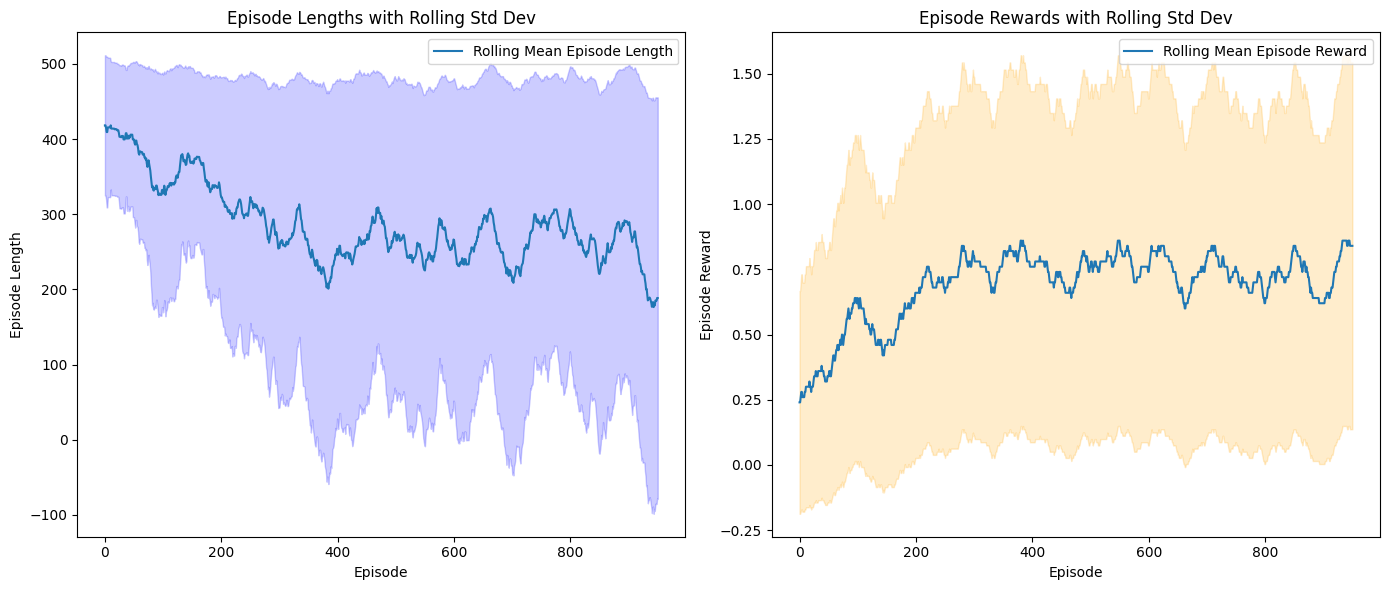

In [38]:
# Example data from a single run (replace with your actual data)
import numpy as np
import matplotlib.pyplot as plt
# Generate example data

# Calculate rolling mean and standard deviation
window_size = 50  # Rolling window size
episode_lengths_mean = np.convolve(episode_lengths, np.ones(window_size)/window_size, mode='valid')
episode_lengths_std = np.sqrt(np.convolve(np.square(episode_lengths - episode_lengths_mean[0]), np.ones(window_size)/window_size, mode='valid'))

episode_rewards_mean = np.convolve(episode_rewards, np.ones(window_size)/window_size, mode='valid')
episode_rewards_std = np.sqrt(np.convolve(np.square(episode_rewards - episode_rewards_mean[0]), np.ones(window_size)/window_size, mode='valid'))

# Plotting
plt.figure(figsize=(14, 6))

# Episode Lengths with Rolling Standard Deviation
plt.subplot(1, 2, 1)
plt.plot(episode_lengths_mean, label='Rolling Mean Episode Length')
plt.fill_between(range(len(episode_lengths_mean)), episode_lengths_mean-episode_lengths_std, episode_lengths_mean+episode_lengths_std, color='blue', alpha=0.2)
plt.xlabel('Episode')
plt.ylabel('Episode Length')
plt.title('Episode Lengths with Rolling Std Dev')
plt.legend()

# Episode Rewards with Rolling Standard Deviation
plt.subplot(1, 2, 2)
plt.plot(episode_rewards_mean, label='Rolling Mean Episode Reward')
plt.fill_between(range(len(episode_rewards_mean)), episode_rewards_mean-episode_rewards_std, episode_rewards_mean+episode_rewards_std, color='orange', alpha=0.2)
plt.xlabel('Episode')
plt.ylabel('Episode Reward')
plt.title('Episode Rewards with Rolling Std Dev')
plt.legend()

plt.tight_layout()
plt.show()


**3C**

In [39]:
# Epsilon Decay Parameters
epsilon_start = 1.0  # Starting value of epsilon
epsilon_end = 0.1   # Minimum value of epsilon
num_episodes = 1000  # Total number of episodes
decay_episodes = 600  # Number of episodes over which to decay epsilon

# Calculate the decay rate per episode
epsilon_decay = (epsilon_start - epsilon_end) / decay_episodes

# Function to get the current value of epsilon based on the episode number
def get_epsilon(current_episode):
    current_epsilon = max(epsilon_start - current_episode * epsilon_decay, epsilon_end)
    return current_epsilon

def run_semi_gradient_sarsa_with_aggregation(env, aggregate_state_fn, feature_fn, num_aggregated_states, num_episodes=1000, alpha=0.1, gamma=0.95, epsilon_start=1.0, epsilon_end=0.1, decay_episodes=800):
    global weights
    weights = np.zeros((num_actions, num_aggregated_states))
    episode_lengths = np.zeros(num_episodes)
    episode_rewards = np.zeros(num_episodes)

    for episode in range(num_episodes):
        epsilon = get_epsilon(episode)  # Dynamic epsilon
        state = env.reset()
        action = epsilon_greedy_policy(state, epsilon)
        done = False
        total_reward = 0
        steps = 0

        while not done:
            aggregated_state = aggregate_state_fn(state)
            next_state, reward, done, _ = env.step(Action(action))
            next_aggregated_state = aggregate_state_fn(next_state)
            features = feature_fn(aggregated_state, num_aggregated_states)
            next_action = epsilon_greedy_policy(next_state, epsilon) if not done else None
            q_target = reward if done else reward + gamma * get_approximate_q_value(next_state, next_action, weights, aggregate_state_fn, feature_fn)
            td_error = q_target - get_approximate_q_value(state, action, weights, aggregate_state_fn, feature_fn)
            weights[action] += alpha * td_error * features
            state, action = next_state, next_action
            total_reward += reward
            steps += 1

        episode_lengths[episode] = steps
        episode_rewards[episode] = total_reward

    return episode_lengths, episode_rewards


In [40]:
env_cols, env_rows = 11, 11

def get_aggregated_state_room_corners(pos):
    room_width = env_cols // 2  # Assuming a grid divided into four rooms
    room_height = env_rows // 2
    room_id = get_aggregated_state(pos)

    # Determine the quarter of the room
    x_offset = pos[0] % room_width
    y_offset = pos[1] % room_height
    if x_offset < room_width // 2 and y_offset < room_height // 2:
        quarter = 0
    elif x_offset >= room_width // 2 and y_offset < room_height // 2:
        quarter = 1
    elif x_offset < room_width // 2 and y_offset >= room_height // 2:
        quarter = 2
    else:
        quarter = 3

    return room_id * 4 + quarter


In [41]:
def get_aggregated_state_proximity_to_center(pos):
    center_x, center_y = env_cols // 4, env_rows // 4  # Center for each quadrant
    room_id = get_aggregated_state(pos)
    room_center_x = (room_id % 2) * 2 * center_x
    room_center_y = (room_id // 2) * 2 * center_y
    if abs(pos[0] - room_center_x) <= center_x // 2 and abs(pos[1] - room_center_y) <= center_y // 2:
        return room_id * 2  # Closer to the center
    else:
        return room_id * 2 + 1  # Further from the center

In [42]:
def get_features_room_corners(aggregated_state, num_aggregated_states=16):  # 4 rooms * 4 quarters each
    feature_vector = np.zeros(num_aggregated_states)
    feature_vector[aggregated_state] = 1
    return feature_vector

def get_features_central_area(aggregated_state, num_aggregated_states=8):  # 4 rooms * central/peripheral
    feature_vector = np.zeros(num_aggregated_states)
    feature_vector[aggregated_state] = 1
    return feature_vector


In [43]:
# Example calls to run SARSA for each aggregation function (placeholders for actual functions),
num_aggregated_states = 4
episode_lengths_basic, episode_rewards_basic = run_semi_gradient_sarsa_with_aggregation(env, get_aggregated_state, get_features, num_aggregated_states, num_episodes)


In [44]:
num_aggregated_states2 = 16
episode_lengths_corners, episode_rewards_corners = run_semi_gradient_sarsa_with_aggregation(env, get_aggregated_state_room_corners, get_features_room_corners, num_aggregated_states2, num_episodes)

In [45]:
num_aggregated_states = 8
episode_lengths_central, episode_rewards_central = run_semi_gradient_sarsa_with_aggregation(env, get_aggregated_state_proximity_to_center, get_features_central_area, num_aggregated_states, num_episodes)

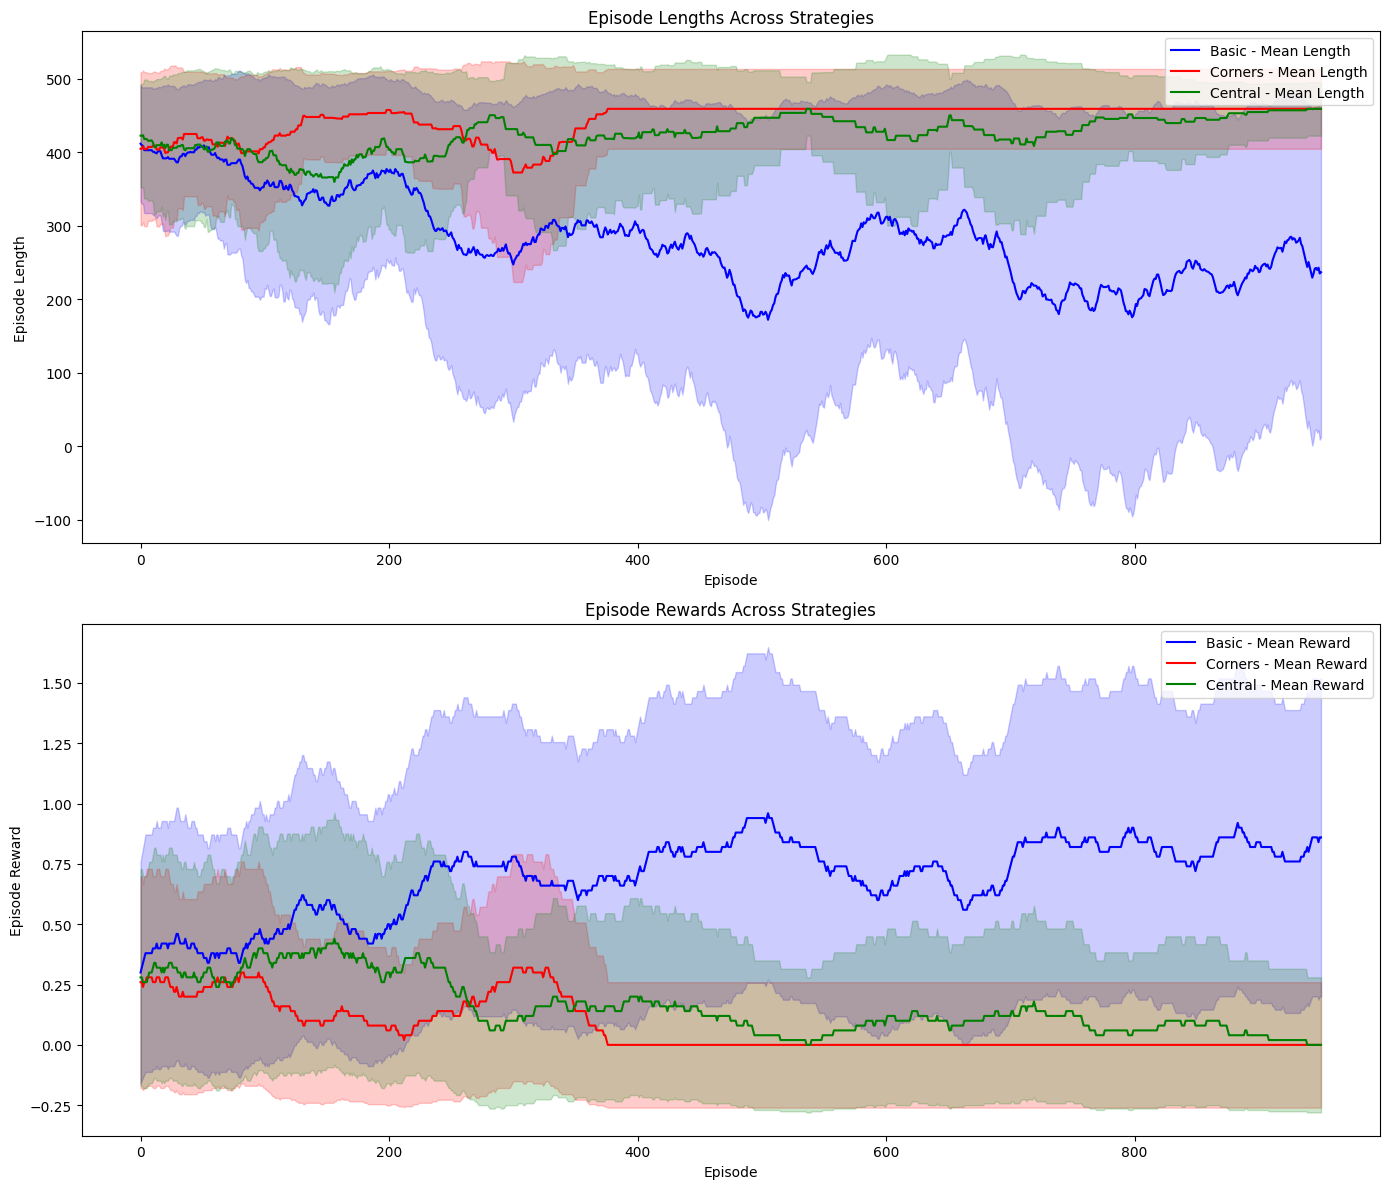

In [46]:
# Assuming num_episodes is defined and is the same for all strategies
num_episodes = 1000

# Define a function to calculate rolling mean and std deviation
def calculate_rolling_statistics(data, window_size=50):
    mean = np.convolve(data, np.ones(window_size) / window_size, mode='valid')
    std = np.sqrt(np.convolve(np.square(data - mean[0]), np.ones(window_size) / window_size, mode='valid'))
    return mean, std

# Calculate rolling statistics for each strategy
lengths_mean_basic, lengths_std_basic = calculate_rolling_statistics(episode_lengths_basic)
lengths_mean_corners, lengths_std_corners = calculate_rolling_statistics(episode_lengths_corners)
lengths_mean_central, lengths_std_central = calculate_rolling_statistics(episode_lengths_central)

rewards_mean_basic, rewards_std_basic = calculate_rolling_statistics(episode_rewards_basic)
rewards_mean_corners, rewards_std_corners = calculate_rolling_statistics(episode_rewards_corners)
rewards_mean_central, rewards_std_central = calculate_rolling_statistics(episode_rewards_central)

# Plotting
plt.figure(figsize=(14, 12))

# Episode Lengths with Rolling Standard Deviation
plt.subplot(2, 1, 1)
plt.plot(lengths_mean_basic, label='Basic - Mean Length', color='blue')
plt.fill_between(range(len(lengths_mean_basic)), lengths_mean_basic-lengths_std_basic, lengths_mean_basic+lengths_std_basic, color='blue', alpha=0.2)
plt.plot(lengths_mean_corners, label='Corners - Mean Length', color='red')
plt.fill_between(range(len(lengths_mean_corners)), lengths_mean_corners-lengths_std_corners, lengths_mean_corners+lengths_std_corners, color='red', alpha=0.2)
plt.plot(lengths_mean_central, label='Central - Mean Length', color='green')
plt.fill_between(range(len(lengths_mean_central)), lengths_mean_central-lengths_std_central, lengths_mean_central+lengths_std_central, color='green', alpha=0.2)
plt.xlabel('Episode')
plt.ylabel('Episode Length')
plt.title('Episode Lengths Across Strategies')
plt.legend()

# Episode Rewards with Rolling Standard Deviation
plt.subplot(2, 1, 2)
plt.plot(rewards_mean_basic, label='Basic - Mean Reward', color='blue')
plt.fill_between(range(len(rewards_mean_basic)), rewards_mean_basic-rewards_std_basic, rewards_mean_basic+rewards_std_basic, color='blue', alpha=0.2)
plt.plot(rewards_mean_corners, label='Corners - Mean Reward', color='red')
plt.fill_between(range(len(rewards_mean_corners)), rewards_mean_corners-rewards_std_corners, rewards_mean_corners+rewards_std_corners, color='red', alpha=0.2)
plt.plot(rewards_mean_central, label='Central - Mean Reward', color='green')
plt.fill_between(range(len(rewards_mean_central)), rewards_mean_central-rewards_std_central, rewards_mean_central+rewards_std_central, color='green', alpha=0.2)
plt.xlabel('Episode')
plt.ylabel('Episode Reward')
plt.title('Episode Rewards Across Strategies')
plt.legend()

plt.tight_layout()
plt.show()


From the plots:

- **Episode Lengths**: The top graph with the episode lengths suggests that:
  - The "Basic" strategy has consistent performance, not changing much over time.
  - The "Corners" strategy varies a lot more, which might mean it's not as stable.
  - The "Central" strategy also has some ups and downs but generally does better than "Corners".

- **Episode Rewards**: The bottom graph with the rewards shows:
  - All strategies seem to get better as they go, earning more rewards in later episodes.
  - The "Basic" strategy is getting lower rewards than the other two, but it's pretty steady.
  - "Corners" and "Central" go up and down but have higher rewards on average than "Basic".

In simpler terms, while the "Basic" approach is steady, it's not doing as well in terms of rewards. "Corners" and "Central" are a bit all over the place, but they do get better results at the end of the day. It looks like having more details about where the agent is can help, even if it makes things a bit more unpredictable.

**3d**

In [47]:
def get_features_xy(state, env_rows=11, env_cols=11):
    """
    Generate a feature vector for the given state based on the agent's (x, y) coordinates.

    Args:
    - state: A tuple representing the agent's current position (x, y).
    - env_rows: The number of rows in the environment.
    - env_cols: The number of columns in the environment.

    Returns:
    - A numpy array representing the feature vector for the given state.
    """
    x, y = state
    # Normalize x and y to be between 0 and 1
    x_normalized = x / env_cols
    y_normalized = y / env_rows
    return np.array([x_normalized, y_normalized, 1])


In [50]:
# def get_approximate_q_value_linapx(state, action, weights, feature_fn):
#     features = feature_fn(state)
#     return np.dot(weights[action], features)

# def get_gradient(features):
#     return features


In [51]:
def run_semi_gradient_sarsa_linear_approximation(env, feature_fn, num_episodes=1000, alpha=0.1, gamma=0.95, epsilon_start=1.0, epsilon_end=0.1, decay_episodes=800):
    num_actions = 4
    num_features = 3  # x coordinate, y coordinate, and constant term
    weights = np.zeros((num_actions, num_features))

    episode_lengths = np.zeros(num_episodes, dtype=int)
    episode_rewards = np.zeros(num_episodes)

    for episode in range(num_episodes):
        epsilon = max(epsilon_end, epsilon_start - (episode / decay_episodes) * (epsilon_start - epsilon_end))
        state = env.reset()
        features = feature_fn(state)
        action = np.random.choice(num_actions) if np.random.rand() < epsilon else np.argmax([np.dot(weights[a], features) for a in range(num_actions)])
        done = False
        total_reward = 0
        steps = 0

        while not done:
            next_state, reward, done, _ = env.step(action)
            next_features = feature_fn(next_state)
            next_action = np.random.choice(num_actions) if np.random.rand() < epsilon else np.argmax([np.dot(weights[a], next_features) for a in range(num_actions)])

            # SARSA Update
            q_target = reward if done else reward + gamma * np.dot(weights[next_action], next_features)
            td_error = q_target - np.dot(weights[action], features)
            weights[action] += alpha * td_error * features

            state, features, action = next_state, next_features, next_action
            total_reward += reward
            steps += 1

        episode_lengths[episode] = steps
        episode_rewards[episode] = total_reward

    return episode_lengths, episode_rewards


In [52]:
episode_lengths_linearapx, episode_rewards_linearapx = run_semi_gradient_sarsa_linear_approximation(env, get_features_xy, num_episodes)


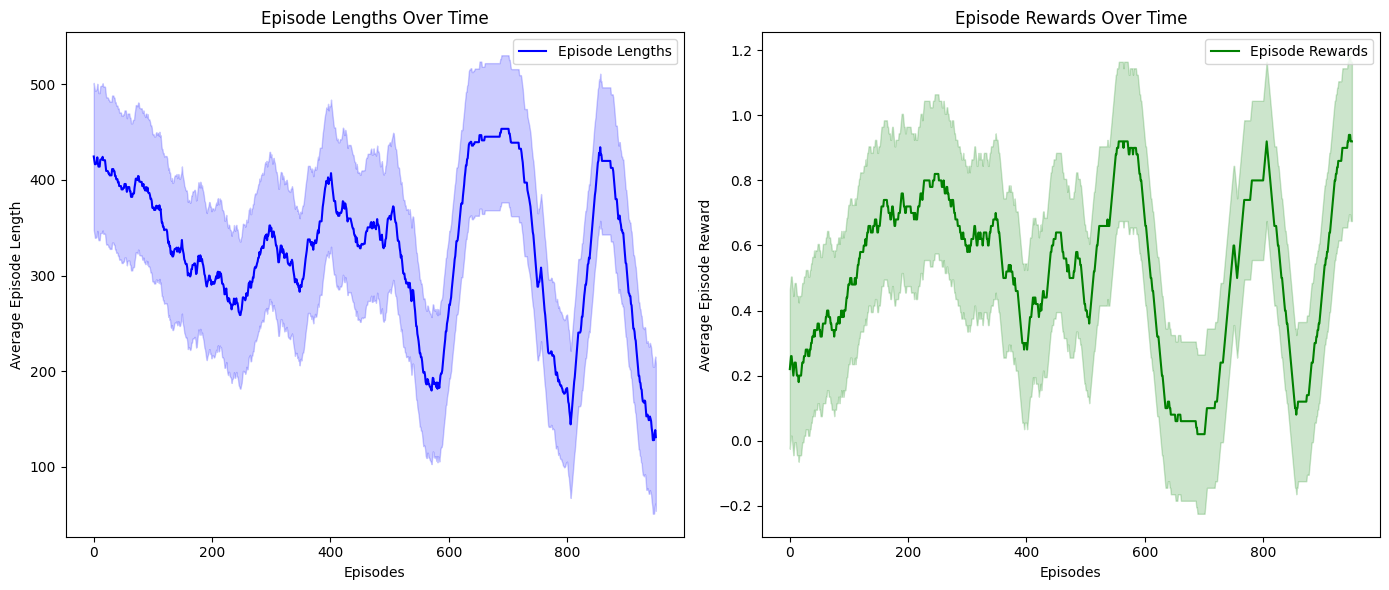

In [53]:
import numpy as np
import matplotlib.pyplot as plt

# Rolling mean and standard deviation calculation
window_size = 50
episode_lengths_mean = np.convolve(episode_lengths_linearapx, np.ones(window_size)/window_size, mode='valid')
episode_rewards_mean = np.convolve(episode_rewards_linearapx, np.ones(window_size)/window_size, mode='valid')

# Plotting
plt.figure(figsize=(14, 6))

# Episode Lengths
plt.subplot(1, 2, 1)
plt.plot(episode_lengths_mean, label='Episode Lengths', color='blue')
plt.fill_between(range(len(episode_lengths_mean)), episode_lengths_mean - np.std(episode_lengths_mean), episode_lengths_mean + np.std(episode_lengths_mean), color='blue', alpha=0.2)
plt.title('Episode Lengths Over Time')
plt.xlabel('Episodes')
plt.ylabel('Average Episode Length')
plt.legend()

# Episode Rewards
plt.subplot(1, 2, 2)
plt.plot(episode_rewards_mean, label='Episode Rewards', color='green')
plt.fill_between(range(len(episode_rewards_mean)), episode_rewards_mean - np.std(episode_rewards_mean), episode_rewards_mean + np.std(episode_rewards_mean), color='green', alpha=0.2)
plt.title('Episode Rewards Over Time')
plt.xlabel('Episodes')
plt.ylabel('Average Episode Reward')
plt.legend()

plt.tight_layout()
plt.show()


3e

**5d**

Computational Complexity: Calculating the expectation necessitates integrating over all possible next states, which can be computationally expensive or impractical for large state spaces.

Sampling Error: In practice, we estimate the expectation using samples, which introduces variability and may necessitate a large number of samples to accurately estimate the true gradient.

Function Approximation Error: The product of expectations does not equal the expectation of the product, resulting in extra approximation mistakes, particularly when employing function approximation methods such as neural networks.
These challenges can be addressed by employing computationally efficient function approximation techniques and constructing algorithms capable of properly sampling or approximating necessary expectations. Ensemble approaches, importance sampling, and variance minimization strategies, for example, can all help to overcome these issues.